In [32]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

In [33]:
# directory where images are stored
DIR = "C:/Users/susarlas/Desktop/POC2/folders"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    folder_characters = ['e', 't']
    
    # dictionary where we will store the stats
    stats = []
    
    for folder_name in folder_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, folder_name)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [34]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
emai,email,16
training ta,training tax,16


In [35]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [36]:
codes = ["emai", "training ta"]
images, labels = load_images(codes)

In [37]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code emai


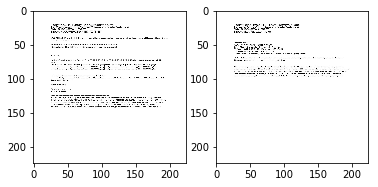

2 random images for code training ta


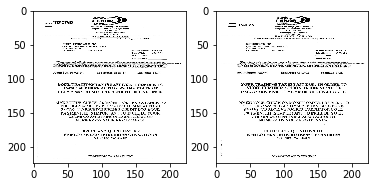

In [38]:
show_random_images(images, labels)

In [39]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [40]:
images, labels = normalise_images(images, labels)


In [41]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=728)
    
    return X_train, y_train

In [42]:
X_train, y_train = shuffle_data(images, labels)


In [43]:
# Load the models with ImageNet weights

vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))



In [44]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [45]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

VGG16 flattened output has 25088 features


In [46]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [47]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

KMeans: 

VGG16:
Training took 11.108235120773315 seconds


In [48]:
# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)

In [49]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [50]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)

In [51]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1
emai,16,0
training ta,0,16


In [52]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["emai", "training ta"]

In [53]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]

In [54]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))

KMeans VGG16: 
	F1 Score: 1.00000000   |   Accuracy: 1.00000000


In [55]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    return vgg16


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output = all_covnet_transform(data)
    
    
    # Cluster
    clusters = len(codes)
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)

    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
 
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    return  K_vgg16_pred, images, labels

32 32
2 random images for code emai


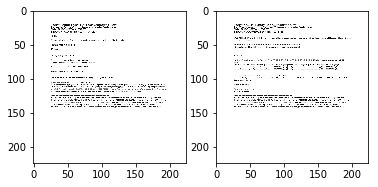

2 random images for code training ta


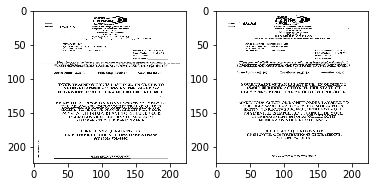

Training took 9.712409496307373 seconds
KMeans VGG16: 
              0   1
emai         16   0
training ta   0  16


In [56]:
outputs = image_load_to_cluster_count(codes)

In [57]:
# Let's define a function for scores
def scoring(vgg16_cluster_code,  outputs):
    vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
    print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))

In [58]:
scoring(vgg16_cluster_code, outputs)

KMeans VGG16: 
	F1 Score: 1.00000000   |   Accuracy: 1.00000000


In [59]:
vgg16_cluster_count

,0,1
emai,16,0
training ta,0,16


In [60]:
type(vgg16_cluster_count)

pandas.core.frame.DataFrame

In [61]:
type(outputs)

tuple